Sebastian Raschka   
last updated: 04/14/2014  

[Link to this IPython Notebook on GitHub](https://github.com/rasbt/pattern_classification/blob/master/stat_pattern_class/supervised/parametric/parameter_estimation/maximum_likelihood_estimate.ipynb)

<hr>
I am really looking forward to your comments and suggestions to improve and extend this tutorial! Just send me a quick note   
via Twitter: [@rasbt](https://twitter.com/rasbt)  
or Email: [bluewoodtree@gmail.com](mailto:bluewoodtree@gmail.com)
<hr>

#Maximum Likelihood Estimation for Statistical Pattern Classification

# Sections

- [Introduction](#introduction)
- [1) A simple case where the parameters are known - no MLE required](#one)
    - [Generating some sample data](#sample_data)
    - [Plotting the sample data](#plotting_data)
    - [Defining the objective function and decision rule](#objective_function)
    - [Implementing the discriminant function](#discriminant_functions)
    - [Implementing the decision rule (classifier)](#decision_rule)
    - [Classifying our sample data](#classifying)
    - [Drawing the confusion matrix and calculating the empirical error](#confusion_matrix)
- [2) Assuming that the parameters are unknown - using MLE](#two)
    - [About the Maximum Likelihood Estimate (MLE)](#about_mle)
    - [MLE of the mean vector $\pmb \mu$](#mle_mu)
    - [MLE of the covariance matrix $\pmb \Sigma$](#mle_cov)
    - [Classification using our estimated parameters](#classifying_mle)
    - [Conclusion](#conclusion)

<br>
<br>
<a name='introduction'></a>
# Introduction

Popular applications for Maximum Likelihood Estimates are the typical statistical pattern classification tasks, and in the past, I posted some [examples](https://github.com/rasbt/pattern_classification#param) using Bayes' classifiers for which the **probabilistic models and parameters were known**. In those cases, the design of the classifier was rather easy, however, in real applications, we are rarely given this information; this is where the Maximum Likelihood Estimate comes into play.

However, the Maximum Likelihood Estimate still **requires partial knowledge** about the problem: We have to assume that the **model of the class conditional densities is known** (e.g., that the data follows typical Gaussian distribution). In contrast, non-parametric approaches like the Parzen-window technqiue do not require prior information about the distribution of the data (I will discuss this technique in more detail in a future article, the IPython notebook is already in preparation).  

**To summarize the problem:** Using MLE, we want to estimate the values of the parameters of a given distribution for the class-conditional densities, for example, the *mean* and *variance* assuming that the class-conditional densities are *normal*  distributed (Gaussian) with $p(\pmb x \; | \; \omega_i) \sim N(\mu, \sigma^2)$.

To illustrate the problem with an example, we will first take a look at a case where we already know the parameters, and then we will use the same dataset and estimate the parameters. This will give us some idea about the performance of the classifier using the estimated parameters. 

<br>
<br>
<a name='one'></a>
# 1) A simple case where the parameters are known - no MLE required

Imagine that we want to classify data consisting of two-dimensional patterns, $\pmb{x} = [x_1, x_2]^t$ that could belong to 1 out of 3 classes $\omega_1,\omega_2,\omega_3$. 

Let's assume the following information about the model and the parameters are known:

####model: continuous univariate normal (Gaussian) model for the class-conditional densities


$ p(\pmb x | \omega_j) \sim N(\pmb \mu|\Sigma) $

$ p(\pmb x | \omega_j) \sim \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$

$p([x_1, x_2]^t |\omega_1) ∼ N([0,0]^t,3I), \\
p([x_1, x_2]^t |\omega_2) ∼ N([9,0]^t,3I), \\
p([x_1, x_2]^t |\omega_3) ∼ N([6,6]^t,4I),$

#### Means of the sample distributions for 2-dimensional features:

$ \pmb{\mu}_{\,1} = \bigg[ 
\begin{array}{c}
0 \\
0 \\
\end{array} \bigg] $,
$ \; \pmb{\mu}_{\,2} = \bigg[ 
\begin{array}{c}
9 \\
0 \\
\end{array} \bigg] $,
$ \; \pmb{\mu}_{\,3} = \bigg[ 
\begin{array}{c}
6 \\
6 \\
\end{array} \bigg] $


#### Covariance matrices for the statistically independend and identically distributed ('i.i.d') features: 

$ \Sigma_i = \bigg[ 
\begin{array}{cc}
\sigma_{11}^2 & \sigma_{12}^2\\
\sigma_{21}^2 & \sigma_{22}^2 \\
\end{array} \bigg] \\  
\Sigma_1 = \bigg[ 
\begin{array}{cc}
3 & 0\\
0 & 3 \\
\end{array} \bigg] \\
\Sigma_2 = \bigg[ 
\begin{array}{cc}
3 & 0\\
0 & 3 \\
\end{array} \bigg] \\
\Sigma_3 = \bigg[ 
\begin{array}{cc}
4 & 0\\
0 & 4 \\
\end{array} \bigg] \\$

#### Equal prior probabilities
$P(\omega_1\; |\; \pmb x) \; = \;  P(\omega_2\; |\; \pmb x) \; = \; P(\omega_3\; |\; \pmb x) \; = \frac{1}{3}$

<br>
<br>
<a name='sample_data'></a>
## Generating some sample data
Given those information, let us draw some random data from a Gaussian distribution.

In [1]:
import numpy as np

np.random.seed(123456)

# Generate 100 random patterns for class1
mu_vec1 = np.array([[0],[0]])
cov_mat1 = np.array([[3,0],[0,3]])
x1_samples = np.random.multivariate_normal(mu_vec1.ravel(), cov_mat1, 100)

# Generate 100 random patterns for class2
mu_vec2 = np.array([[9],[0]])
cov_mat2 = np.array([[3,0],[0,3]])
x2_samples = np.random.multivariate_normal(mu_vec2.ravel(), cov_mat2, 100)

# Generate 100 random patterns for class3
mu_vec3 = np.array([[6],[6]])
cov_mat3 = np.array([[4,0],[0,4]])
x3_samples = np.random.multivariate_normal(mu_vec3.ravel(), cov_mat3, 100)


<br>
<br>
<a name='plotting_data'></a>
## Plotting the sample data
To get an intuitive idea of how our data looks like, let us visualize it in a simple scatter plot.

Populating the interactive namespace from numpy and matplotlib


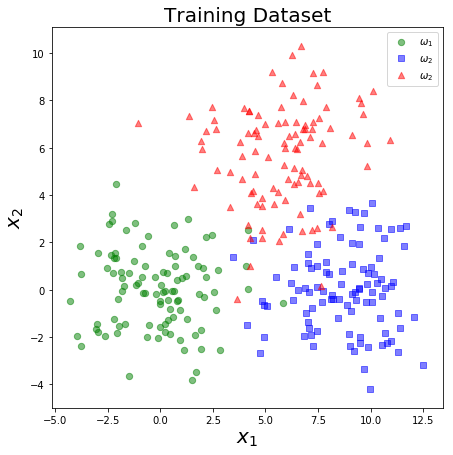

In [2]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x1_samples[:,0], x1_samples[:,1], marker='o', color='green', s=40, alpha=0.5, label='$\omega_1$')
ax.scatter(x2_samples[:,0], x2_samples[:,1], marker='s', color='blue', s=40, alpha=0.5, label='$\omega_2$')
ax.scatter(x3_samples[:,0], x3_samples[:,1], marker='^', color='red', s=40, alpha=0.5, label='$\omega_2$')
plt.legend(loc='upper right') 
plt.title('Training Dataset', size=20)
plt.ylabel('$x_2$', size=20)
plt.xlabel('$x_1$', size=20)
plt.show()

<br>
<br>
<a name='objective_function'></a>

## Defining the objective function and decision rule

Here, our **objective function** is to maximize the discriminant function $g_i(\pmb x)$, which we define as the posterior probability to perform a **minimum-error classification** (Bayes classifier). 

$ g_1(\pmb x) = P(\omega_1 | \; \pmb{x}), \quad  g_2(\pmb{x}) = P(\omega_2 | \; \pmb{x}), \quad  g_3(\pmb{x}) = P(\omega_2 | \; \pmb{x})$

So that our decision rule is to choose the class $\omega_i$ for which $g_i(\pmb x)$ is max., where  
 $ \quad g_i(\pmb{x}) = \pmb{x}^{\,t} \bigg( - \frac{1}{2} \Sigma_i^{-1} \bigg) \pmb{x} + \bigg( \Sigma_i^{-1} \pmb{\mu}_{\,i}\bigg)^t \pmb x + \bigg( -\frac{1}{2} \pmb{\mu}_{\,i}^{\,t}  \Sigma_{i}^{-1} \pmb{\mu}_{\,i} -\frac{1}{2} ln(|\Sigma_i|)\bigg) $

<br>
<br>
<a name='discriminant_functions'></a>
## Implementing the discriminant function
Now, let us implement the discriminant function for $g_i(\pmb x)$ in Python code:

In [3]:
def discriminant_function(x_vec, cov_mat, mu_vec):
    """
    Calculates the value of the discriminant function for a dx1 dimensional
    sample given the covariance matrix and mean vector.
    
    Keyword arguments:
        x_vec: A dx1 dimensional numpy array representing the sample.
        cov_mat: numpy array of the covariance matrix.
        mu_vec: dx1 dimensional numpy array of the sample mean.
    
    Returns a float value as result of the discriminant function.
    
    """
    W_i = (-1/2) * np.linalg.inv(cov_mat)
    assert(W_i.shape[0] > 1 and W_i.shape[1] > 1), 'W_i must be a matrix'
    
    w_i = np.linalg.inv(cov_mat).dot(mu_vec)
    assert(w_i.shape[0] > 1 and w_i.shape[1] == 1), 'w_i must be a column vector'
    
    omega_i_p1 = (((-1/2) * (mu_vec).T).dot(np.linalg.inv(cov_mat))).dot(mu_vec)
    omega_i_p2 = (-1/2) * np.log(np.linalg.det(cov_mat))
    omega_i = omega_i_p1 - omega_i_p2
    assert(omega_i.shape == (1, 1)), 'omega_i must be a scalar'
    
    g = ((x_vec.T).dot(W_i)).dot(x_vec) + (w_i.T).dot(x_vec) + omega_i
    return float(g)

<br>
<br>
<a name='decision_rule'></a>
## Implementing the decision rule (classifier)
Next, we need to implement the code that returns the max. $g_i(\pmb x)$ with the corresponding class label:

In [4]:
import operator

def classify_data(x_vec, g, mu_vecs, cov_mats):
    """
    Classifies an input sample into 1 out of 3 classes determined by
    maximizing the discriminant function g_i().
    
    Keyword arguments:
        x_vec: A dx1 dimensional numpy array representing the sample.
        g: The discriminant function.
        mu_vecs: A list of mean vectors as input for g.
        cov_mats: A list of covariance matrices as input for g.
    
    Returns a tuple (g_i()_value, class label).
    
    """
    assert(len(mu_vecs) == len(cov_mats)), 'Number of mu_vecs and cov_mats must be equal.'
    
    g_vals = []
    for m,c in zip(mu_vecs, cov_mats): 
        g_vals.append(g(x_vec, mu_vec=m, cov_mat=c))
    
    max_index, max_value = max(enumerate(g_vals), key=operator.itemgetter(1))
    return (max_value, max_index + 1)

<br>
<br>
<a name='classifying'></a>
## Classifying the sample data
Using the discriminant function and classifier that we just implemented above, let us classify our sample data. (I have to apologize for the long code below, but I thought it makes it a little more clear of what exactly is going on)

In [5]:
class1_as_1 = 0
class1_as_2 = 0
class1_as_3 = 0
for row in x1_samples:
    g = classify_data(
        row, 
        discriminant_function,
        [mu_vec1, mu_vec2, mu_vec3],
        [cov_mat1, cov_mat2, cov_mat3]
    )
    if g[1] == 2:
        class1_as_2 += 1
    elif g[1] == 3:
        class1_as_3 += 1
    else:
        class1_as_1 += 1

class2_as_1 = 0
class2_as_2 = 0
class2_as_3 = 0
for row in x2_samples:
    g = classify_data(
        row, 
        discriminant_function,
        [mu_vec1, mu_vec2, mu_vec3],
        [cov_mat1, cov_mat2, cov_mat3]
    )
    if g[1] == 2:
        class2_as_2 += 1
    elif g[1] == 3:
        class2_as_3 += 1
    else:
        class2_as_1 += 1

class3_as_1 = 0
class3_as_2 = 0
class3_as_3 = 0
for row in x3_samples:
    g = classify_data(
        row, 
        discriminant_function,
        [mu_vec1, mu_vec2, mu_vec3],
        [cov_mat1, cov_mat2, cov_mat3]
    )
    if g[1] == 2:
        class3_as_2 += 1
    elif g[1] == 3:
        class3_as_3 += 1
    else:
        class3_as_1 += 1

<br>
<br>
<a name='confusion matrix'></a>
## Drawing the confusion matrix and calculating the empirical error
Now, that we classified our data, let us plot the confusion matrix to see what the empirical error looks like.

In [6]:
import prettytable

confusion_mat = prettytable.PrettyTable(["sample dataset", "w1 (predicted)", "w2 (predicted)", "w3 (predicted)"])
confusion_mat.add_row(["w1 (actual)",class1_as_1, class1_as_2, class1_as_3])
confusion_mat.add_row(["w2 (actual)",class2_as_1, class2_as_2, class2_as_3])
confusion_mat.add_row(["w3 (actual)",class3_as_1, class3_as_2, class3_as_3])
print(confusion_mat)
misclass = x1_samples.shape[0]*3 - class1_as_1 - class2_as_2 - class3_as_3
bayes_err = misclass / (len(x1_samples)*3)
print('Empirical Error: {:.2f} ({:.2f}%)'.format(bayes_err, bayes_err * 100))

+----------------+----------------+----------------+----------------+
| sample dataset | w1 (predicted) | w2 (predicted) | w3 (predicted) |
+----------------+----------------+----------------+----------------+
|  w1 (actual)   |       98       |       1        |       1        |
|  w2 (actual)   |       2        |       93       |       5        |
|  w3 (actual)   |       1        |       2        |       97       |
+----------------+----------------+----------------+----------------+
Empirical Error: 0.04 (4.00%)


<br>
<br>
<a name='two'></a>
# 2) Assuming that the parameters are unknown - using MLE

<br>
<br>
<a name='about_mle'></a>
### About the Maximum Likelihood Estimate (MLE)

In contrast to the first section, let us assume that we only know the number of parameters for the class conditional densities $p (\; \pmb x \; | \; \omega_i)$, and we want to use a Maximum Likelihood Estimation (MLE) to estimate the quantities of these parameters from the training data (*here:* our random sample data).


Given the information about the form of the model - the data is normal distributed - the 2 parameters to be estimated are $\pmb \mu_i$ and $\pmb \Sigma_i$, which are summarized by the   
parameter vector $\pmb \theta_i = \bigg[ \begin{array}{c}
\ \theta_{i1} \\
\ \theta_{i2} \\
\end{array} \bigg]=
\bigg[ \begin{array}{c}
\pmb \mu_i \\
\pmb \Sigma_i \\
\end{array} \bigg]$ 

For the Maximum Likelihood Estimate (MLE), we assume that we have a set of samples $D = \left\{ \pmb x_1, \pmb x_2,..., \pmb x_n \right\} $ that are *i.i.d.* (independent and identically distributed, drawn with probability $p(\pmb x \; | \; \omega_i, \; \pmb \theta_i) $).  
Thus, we can **work with each class separately** and omit the class labels, so that we write the probability density as $p(\pmb x \; | \; \pmb \theta)$ 

<br>
<br>
### Likelihood of $ \pmb \theta $

Thus, the probability of observing $D = \left\{ \pmb x_1, \pmb x_2,..., \pmb x_n \right\} $ is: 
<br>
<br>
$p(D\; | \;  \pmb \theta\;) = p(\pmb x_1 \; | \; \pmb \theta\;)\; \cdot \; p(\pmb x_2 \; | \;\pmb \theta\;) \; \cdot \;...  \; p(\pmb x_n \; | \; \pmb \theta\;) = \prod_{k=1}^{n} \; p(\pmb x_k \pmb \; | \; \pmb \theta \;)$  
<br>
Where $p(D\; | \;  \pmb  \theta\;)$ is also called the ***likelihood of $\pmb\ \theta$***.

We are given the information that $p([x_1,x_2]^t) \;∼ \; N(\pmb \mu,\pmb \Sigma) $ (remember that we dropped the class labels, since we are working with every class separately).

And the mutlivariate normal density is given as:
$\quad \quad p(\pmb x) = \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$

So that  
$p(D\; | \;  \pmb \theta\;) = \prod_{k=1}^{n} \; p(\pmb x_k \pmb \; | \; \pmb \theta \;) =  \prod_{k=1}^{n} \; \frac{1}{(2\pi)^{d/2} \; |\Sigma|^{1/2}} exp \bigg[ -\frac{1}{2}(\pmb x - \pmb \mu)^t \Sigma^{-1}(\pmb x - \pmb \mu) \bigg]$

and the log of the multivariate density

$ l(\pmb\theta) =  \sum\limits_{k=1}^{n} - \frac{1}{2}(\pmb x - \pmb \mu)^t \pmb \Sigma^{-1} \; (\pmb x - \pmb \mu) - \frac{d}{2} \; ln \; 2\pi - \frac{1}{2} \;ln \; |\pmb\Sigma|$

<br>
<br>
#### Maximum Likelihood Estimate (MLE)

In order to obtain the MLE $\boldsymbol{\hat{\theta}}$, we maximize $l (\pmb  \theta)$, which can be done via differentiation:

with 
$\nabla_{\pmb \theta} \equiv \begin{bmatrix}  
\frac{\partial \; }{\partial \; \theta_1} \\ 
\frac{\partial \; }{\partial \; \theta_2}
\end{bmatrix} = \begin{bmatrix} 
\frac{\partial \; }{\partial \; \pmb \mu} \\ 
\frac{\partial \; }{\partial \; \pmb \sigma}
\end{bmatrix}$

$\nabla_{\pmb \theta} l = \sum\limits_{k=1}^n \nabla_{\pmb \theta} \;ln\; p(\pmb x| \pmb \theta) = 0 $

<br>
<br>
<a name='mle_mu'></a>
## MLE of the mean vector $\pmb \mu$

After doing the differentiation, we find that the MLE of the parameter $\pmb\mu$ is given by the equation:  
${\hat{\pmb\mu}} = \frac{1}{n} \sum\limits_{k=1}^{n} \pmb x_k$

As you can see, this is simply the mean of our dataset, so we can implement the code very easily and compare the estimate to the actual values for $\pmb \mu$.

In [7]:
import prettytable

mu_est1 = np.array([[sum(x1_samples[:,0])/len(x1_samples[:,0])],[sum(x1_samples[:,1])/len(x1_samples[:,1])]])
mu_est2 = np.array([[sum(x2_samples[:,0])/len(x2_samples[:,0])],[sum(x2_samples[:,1])/len(x2_samples[:,1])]])
mu_est3 = np.array([[sum(x3_samples[:,0])/len(x3_samples[:,0])],[sum(x3_samples[:,1])/len(x3_samples[:,1])]])

mu_mle = prettytable.PrettyTable(["", "mu_1", "mu_2", "mu_3"])
mu_mle.add_row(["MLE",mu_est1, mu_est2, mu_est3])
mu_mle.add_row(["actual",mu_vec1, mu_vec2, mu_vec3])

print(mu_mle)

+--------+-----------------+-----------------+-----------------+
|        |       mu_1      |       mu_2      |       mu_3      |
+--------+-----------------+-----------------+-----------------+
|  MLE   |  [[-0.17370434] |  [[ 8.65908903] |  [[ 5.77749337] |
|        |  [ 0.01919151]] |  [ 0.02617762]] |  [ 5.67218058]] |
| actual |       [[0]      |       [[9]      |       [[6]      |
|        |       [0]]      |       [0]]      |       [6]]      |
+--------+-----------------+-----------------+-----------------+


<br>
<br>
<a name='mle_cov'></a>
## MLE of the covariance matrix $\pmb \Sigma$

Analog to $\pmb \mu$ we can find the equation for the $\pmb\Sigma$ via differentiation - okay the equations are a little bit more involved, but the approach is the same - so that we come to this equation:  

${\hat{\pmb\Sigma}} = \frac{1}{n} \sum\limits_{k=1}^{n} (\pmb x_k - \hat{\mu})(\pmb x_k - \hat{\mu})^t$

which we will also implement in Python code, and then compare to the acutal values of ${\pmb\Sigma}$.

In [8]:
import prettytable

def mle_est_cov(x_samples, mu_est):
    """
    Calculates the Maximum Likelihood Estimate for the covariance matrix.
    
    Keyword Arguments:
        x_samples: np.array of the samples for 1 class, n x d dimensional 
        mu_est: np.array of the mean MLE, d x 1 dimensional
        
    Returns the MLE for the covariance matrix as d x d numpy array.
    
    """
    cov_est = np.zeros((2,2))
    for x_vec in x_samples:
        x_vec = x_vec.reshape(2,1)
        assert(x_vec.shape == mu_est.shape), 'mean and x vector hmust be of equal shape'
        cov_est += (x_vec - mu_est).dot((x_vec - mu_est).T)
    return cov_est / len(x_samples)

cov_est1 = mle_est_cov(x1_samples, mu_est1)
cov_est2 = mle_est_cov(x2_samples, mu_est2)
cov_est3 = mle_est_cov(x3_samples, mu_est3)

cov_mle = prettytable.PrettyTable(["", "covariance_matrix_1", "covariance_matrix_2", "covariance_matrix_3"])
cov_mle.add_row(["MLE", cov_est1, cov_est2, cov_est3])
cov_mle.add_row(['','','',''])
cov_mle.add_row(["actual", cov_mat1, cov_mat2, cov_mat3])

print(cov_mle)


+--------+-----------------------------+-----------------------------+-----------------------------+
|        |     covariance_matrix_1     |     covariance_matrix_2     |     covariance_matrix_3     |
+--------+-----------------------------+-----------------------------+-----------------------------+
|  MLE   |  [[ 3.988021   -0.19957158] |  [[ 3.79760541 -0.04062998] |  [[ 4.35960544  0.51274876] |
|        |  [-0.19957158  2.69991303]] |  [-0.04062998  3.05143476]] |  [ 0.51274876  4.44341942]] |
|        |                             |                             |                             |
| actual |            [[3 0]           |            [[3 0]           |            [[4 0]           |
|        |            [0 3]]           |            [0 3]]           |            [0 4]]           |
+--------+-----------------------------+-----------------------------+-----------------------------+


<br>
<br>
<a name='classifying_mle'></a>

## Classification using our estimated parameters

Using the estimated parameters $\pmb \mu_i$ and $\pmb \Sigma_i$, which we obtained via MLE, we calculate the error on the sample dataset again. 

In [9]:
class1_as_1 = 0
class1_as_2 = 0
class1_as_3 = 0
for row in x1_samples:
    g = classify_data(
        row, 
        discriminant_function,
        [mu_est1, mu_est2, mu_est3],
        [cov_est1, cov_est2, cov_est3]
    )
    if g[1] == 2:
        class1_as_2 += 1
    elif g[1] == 3:
        class1_as_3 += 1
    else:
        class1_as_1 += 1

class2_as_1 = 0
class2_as_2 = 0
class2_as_3 = 0
for row in x2_samples:
    g = classify_data(
        row, 
        discriminant_function,
        [mu_est1, mu_est2, mu_est3],
        [cov_est1, cov_est2, cov_est3]
    )
    if g[1] == 2:
        class2_as_2 += 1
    elif g[1] == 3:
        class2_as_3 += 1
    else:
        class2_as_1 += 1

class3_as_1 = 0
class3_as_2 = 0
class3_as_3 = 0
for row in x3_samples:
    g = classify_data(
        row, 
        discriminant_function,
        [mu_est1, mu_est2, mu_est3],
        [cov_est1, cov_est2, cov_est3]
    )
    if g[1] == 2:
        class3_as_2 += 1
    elif g[1] == 3:
        class3_as_3 += 1
    else:
        class3_as_1 += 1

In [10]:
import prettytable

confusion_mat = prettytable.PrettyTable(["sample dataset", "w1 (predicted)", "w2 (predicted)", "w3 (predicted)"])
confusion_mat.add_row(["w1 (actual)",class1_as_1, class1_as_2, class1_as_3])
confusion_mat.add_row(["w2 (actual)",class2_as_1, class2_as_2, class2_as_3])
confusion_mat.add_row(["w3 (actual)",class3_as_1, class3_as_2, class3_as_3])
print(confusion_mat)
misclass = x1_samples.shape[0]*3 - class1_as_1 - class2_as_2 - class3_as_3
bayes_err = misclass / (len(x1_samples)*3)
print('Empirical Error: {:.2f} ({:.2f}%)'.format(bayes_err, bayes_err * 100))

+----------------+----------------+----------------+----------------+
| sample dataset | w1 (predicted) | w2 (predicted) | w3 (predicted) |
+----------------+----------------+----------------+----------------+
|  w1 (actual)   |       96       |       1        |       3        |
|  w2 (actual)   |       2        |       94       |       4        |
|  w3 (actual)   |       1        |       3        |       96       |
+----------------+----------------+----------------+----------------+
Empirical Error: 0.05 (4.67%)


<br>
<br>
<a name='conclusion'></a>
## Conclusion

I would claim that the results look pretty good! The error rate on our random dataset increased by just 0.67% (from 4.00% to 4.67%) when we estimated $\pmb \mu$ and $\pmb \Sigma$ using MLE.  
In a real application of course, we would have an separate training dataset to derive and estimate the parameters, and a test data set for calculating the error rate. However, I ommitted the usage of to separate datasets here for the sake of brevity.

In [ ]:
tested ; Gopal